<a href="https://colab.research.google.com/github/debanjan02/BreakHis/blob/master/raw/Breakhis_40_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
from sklearn.cluster import KMeans, estimate_bandwidth, MeanShift
from glob import glob
import cv2
import fnmatch
% matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
x = np.load('/content/drive/My Drive/project/x_BreakHis_40.npy')
y = np.load('/content/drive/My Drive/project/y_BreakHis_40_bin.npy')

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 2)
y_valid = to_categorical(y_valid, num_classes = 2)

In [0]:
import keras
#import keras.metrics
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU 
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.applications.resnet50 import ResNet50
input_tensor = Input(shape=(299,299,3))
base_model = ResNet50(input_tensor = input_tensor, include_top = False, pooling = 'average')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(2, activation = 'softmax')(x)
model = Model(base_model.input,x)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='/content/drive/My Drive/project/model_check_path_BreakHis_40_bin_resnet50.hdf5',
                      monitor="val_acc", save_best_only=True, save_weights_only=False)
hist = model.fit(x_train,y_train,batch_size = 32, validation_split=0.2, epochs = 200, verbose=1, callbacks=[mcp])

Instructions for updating:
Use tf.cast instead.
Train on 3830 samples, validate on 958 samples
Epoch 1/200
3830/3830 [==============================] - 226s 59ms/step - loss: 0.5273 - acc: 0.8431 - val_loss: 8.7467 - val_acc: 0.2871
Epoch 2/200
3830/3830 [==============================] - 205s 53ms/step - loss: 0.4825 - acc: 0.8352 - val_loss: 2.1001 - val_acc: 0.6921
Epoch 3/200
3830/3830 [==============================] - 205s 54ms/step - loss: 0.2324 - acc: 0.9089 - val_loss: 0.4951 - val_acc: 0.9092
Epoch 4/200
3830/3830 [==============================] - 204s 53ms/step - loss: 0.2210 - acc: 0.9110 - val_loss: 0.6467 - val_acc: 0.8392
Epoch 5/200
3830/3830 [==============================] - 204s 53ms/step - loss: 0.1381 - acc: 0.9499 - val_loss: 0.5130 - val_acc: 0.8601
Epoch 6/200
3830/3830 [==============================] - 204s 53ms/step - loss: 0.1081 - acc: 0.9580 - val_loss: 0.0918 - val_acc: 0.9614
Epoch 7/200
3830/3830 [==============================] - 204s 53ms/step - los

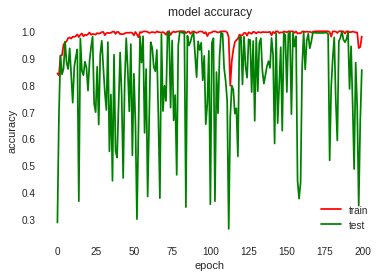

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['acc'], color='red')
ax.plot(hist.history['val_acc'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

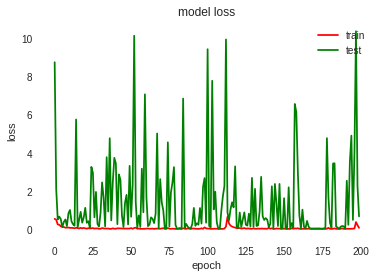

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['loss'], color='red')
ax.plot(hist.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
model.load_weights('/content/drive/My Drive/project/model_check_path_BreakHis_40_bin_resnet50.hdf5')

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(x_valid)
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       372
           1       1.00      1.00      1.00       825

   micro avg       1.00      1.00      1.00      1197
   macro avg       1.00      1.00      1.00      1197
weighted avg       1.00      1.00      1.00      1197



In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

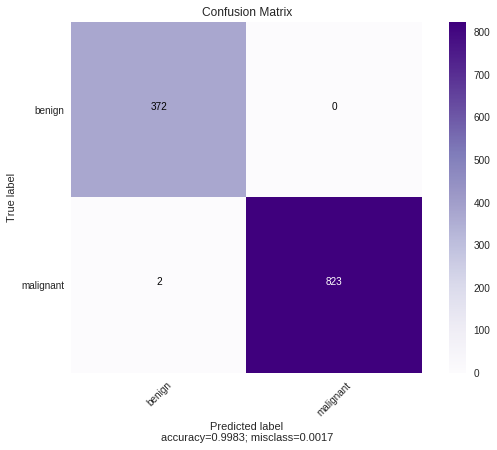

In [0]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      cmap = 'Purples',
                      normalize    = False,
                      target_names = ['benign', 'malignant'],
                      title        = "Confusion Matrix")